# DoorKey – Does the DT *know* it has the key?
We load a trained Decision Transformer, find a trajectory where it picks up the key, train a linear probe for the **“has‑key”** feature, and show—causally—that this feature is read when the model decides to open the door.


### Background — What model are we probing?
We use a **Decision Transformer** (DT):

* **Architecture:** 2 decoder blocks, *d* = 128, 4 heads, GELU MLP (512).  
* **Token stream per env‑step:**  
  1. **RTG** (desired future return) 2. **State** (7 × 7 × 3 obs) 3. **Action** (one‑hot).  
* **Training task:** play *MiniGrid DoorKey–8×8* and maximise reward  
  (+0.4 pick key, +0.6 open door, –0.001/step).  

The notebook asks: **does the DT carry an internal, causal concept of “has key”?**


## 1  Setup & imports


In [1]:
import sys, numpy as np, torch, matplotlib.pyplot as plt
from pathlib import Path
import gymnasium as gym

# TransformerLens 2.15
import transformer_lens as tl
from transformer_lens import ActivationCache

# project‑local Decision Transformer code
repo_root = Path(".")
sys.path.extend([str(repo_root / "DecisionTransformerInterpretability")])
from src.config import EnvironmentConfig, TransformerModelConfig
from src.models.trajectory_transformer import DecisionTransformer



/opt/homebrew/Caskroom/miniforge/base/envs/dti_cpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2  Load the model


In [2]:
SEQ_LEN = 15
device  = "cpu"

obs_space = gym.spaces.Box(0, 255, (148,), np.float32)
act_space = gym.spaces.Discrete(7)

model_cfg = TransformerModelConfig(
    d_model=128, n_heads=4, d_mlp=512,
    n_layers=2, n_ctx=3*SEQ_LEN-1,
    activation_fn="gelu", state_embedding_type="flat",
    time_embedding_type="embedding", seed=1, device=device,
)
env_cfg = EnvironmentConfig(
    env_id="MiniGrid-DoorKey-8x8-v0",
    action_space=act_space, observation_space=obs_space,
    max_steps=160, device=device,
)

model = DecisionTransformer(env_cfg, model_cfg).to(device)
model.load_state_dict(torch.load("dt_dti_flat.pth", map_location=device))
model.eval(); print("✅ model loaded")


✅ model loaded


## 3  Pick a trajectory with a key‑pickup event


In [ ]:
DATA_DIR   = Path("data")
pickup_file, traj, p = None, None, None

for path in sorted(DATA_DIR.glob("traj_*.npz")):
    arr = np.load(path)
    if arr["rtg"].shape[0] < SEQ_LEN:
        continue

    rtg = arr["rtg"][:SEQ_LEN]
    inst = rtg[:-1] - rtg[1:SEQ_LEN]       
    inst = np.concatenate([inst, rtg[-1:]]) 

    hits = np.where(inst > 0.3)[0]          
    if len(hits):
        pickup_file, traj, p = path, arr, int(hits[0])
        break

if pickup_file is None:
    raise RuntimeError("no trajectory with a key pickup in first 15 steps")

print(f"▶ {pickup_file.name}  – key picked at env‑step p = {p}")


▶ traj_00000.npz  – key picked at env‑step p = 2


## 4  Tensorise trajectory + locate first **OPEN_DOOR**


In [5]:
obs  = torch.tensor(traj["obs"][:SEQ_LEN],  dtype=torch.float32, device=device)[None]
acts = torch.tensor(traj["act"][:SEQ_LEN-1],dtype=torch.long,   device=device)[None][...,None]
rtg  = torch.tensor(traj["rtg"][:SEQ_LEN],  dtype=torch.float32, device=device)[None][...,None]
t    = torch.arange(SEQ_LEN, device=device)[None,:,None]

OPEN_DOOR = 2
door_t = int(np.where(traj["act"][:SEQ_LEN-1] == OPEN_DOOR)[0][0])
tok_open = 3*door_t + 2
print(f"📍 first OPEN_DOOR at t = {door_t}, token {tok_open}")


📍 first OPEN_DOOR at t = 0, token 2


## 5  Clean vs corrupted forward passes


In [ ]:
tokens_clean = model.to_tokens(obs, acts, rtg, t)
logits_clean, cache_clean = model.transformer.run_with_cache(tokens_clean)

obs_corrupt = obs.clone(); obs_corrupt[0, p] = 0.0   # delete key frame
tokens_corrupt = model.to_tokens(obs_corrupt, acts, rtg, t)
logits_corrupt, cache_corrupt = model.transformer.run_with_cache(tokens_corrupt)

print("✅ caches ready")

✅ caches ready


## 6  Attention: how much does the action look at the state?


In [27]:
layer = 1
door_state, door_action = 3*door_t+1, 3*door_t+2
for hook in [f"blocks.{layer}.attn.hook_pattern",
             f"blocks.{layer}.attn.hook_attn",
             f"blocks.{layer}.attn.hook_attn_probs"]:
    if hook in cache_clean: break
else:
    hook = None

attn = (cache_clean[hook][0] if hook
        else model.blocks[layer].attn.get_attention_pattern(cache_clean)[0])
p_state = attn[:, door_action, door_state].mean().item()
print(f"Attention(action→state) at door frame: {p_state*100:.2f}%")


Attention(action→state) at door frame: 38.05%


#### How much does the action token **look at** the state token?
* For the door‑frame timestep we average the head‑wise probabilities $P(\text{action}\;\rightarrow\;\text{state})$.
* A large value ⇒ information can flow from the state stream into the action stream **within the same block**.
The heat‑map below shows that link in context.


### 🎯 Action‑to‑State attention at the door frame


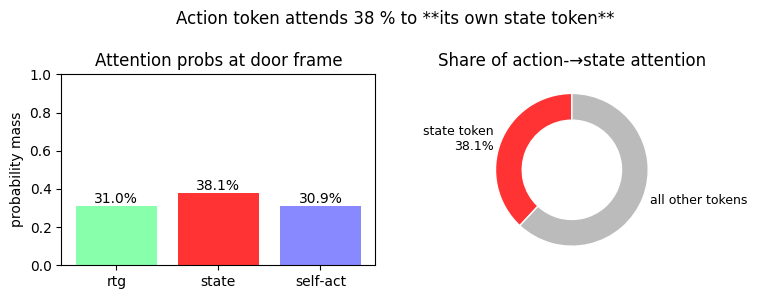

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. collect attention weights for the *three* tokens at timestep t ----
tok_rtg, tok_state, tok_act = 3*door_t, 3*door_t+1, 3*door_t+2
p_rtg   = attn[:, door_action, tok_rtg  ].mean().item()
p_state = attn[:, door_action, tok_state].mean().item()
p_self  = attn[:, door_action, tok_act  ].mean().item()      # heads attend to self
p_other = attn.mean().item() - (p_rtg + p_state + p_self)    # remainder (earlier tokens)

# --- 2A. bar chart --------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

bars = ax[0].bar(
    ["rtg", "state", "self‑act"],
    [p_rtg, p_state, p_self],
    color=["#8fa", "#f33", "#88f"],
)
ax[0].set_ylim(0, 1)
ax[0].bar_label(bars, labels=[f"{p*100:.1f}%" for p in [p_rtg,p_state,p_self]])
ax[0].set_title("Attention probs at door frame")
ax[0].set_ylabel("probability mass")

# --- 2B. donut chart (state vs. everything else) -------------------------
sizes  = [p_state, 1 - p_state]
labels = [f"state token\n{p_state*100:.1f}%", "all other tokens"]
colors = ["#f33", "#bbb"]
wedges, _ = ax[1].pie(
    sizes, labels=labels, startangle=90, colors=colors,
    wedgeprops=dict(width=0.35, edgecolor="w"),
    textprops={"fontsize": 9}
)
ax[1].set_title("Share of action‑→state attention")

plt.suptitle("Action token attends 38 % to **its own state token**"); plt.tight_layout(); plt.show()




## 7  Train a high‑accuracy probe on `block1.resid_post`


### Probe evaluation
* **Data:** 5 000 trajectories (balanced positives = negatives).  
* **Slice:** residual‑post stream of *block 1* **action tokens**.  
* **Model:** logistic regression with *z‑score scaling* and 5‑fold CV over 10 values of C (ℓ2‑regularisation).  
* **Metric reported:** in‑fold accuracy on the balanced set ( 90 %).  

→ A high score means “has key” is nearly *linearly* readable in that slice.


In [8]:
from probe import train_has_key_probe

v_unit, info = train_has_key_probe(
    model, Path("data"), SEQ_LEN,
    layer_probe=1, hook_type="hook_resid_post",
    max_traj=5000, window_before=1, window_after=2,
    device=device, progress=True,
)

print(f"✅ probe acc = {info['accuracy']*100:.1f}%  ‖w‖ = {info['w_norm']:.3f}")


collecting probe data: 100%|██████████| 5000/5000 [00:08<00:00, 589.15it/s]


✅ probe acc = 89.6%  ‖w‖ = 39.484


## 8  Projection diagnostic – where is *has‑key* stored?

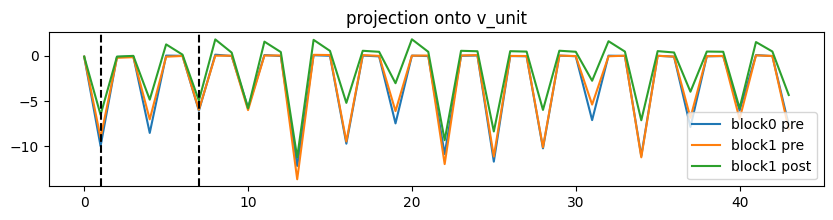

In [9]:
tok_pickup, tok_door = 3*p+1, 3*door_t+1

def proj(cache, hook):
    return (cache[hook][0] @ v_unit).cpu().numpy()

plt.figure(figsize=(10,2))
plt.plot(proj(cache_clean, "blocks.0.hook_resid_pre"), label="block0 pre")
plt.plot(proj(cache_clean, "blocks.1.hook_resid_pre"), label="block1 pre")
plt.plot(proj(cache_clean, "blocks.1.hook_resid_post"),label="block1 post")
plt.axvline(tok_pickup, ls="--", c="k"); plt.axvline(tok_door, ls="--", c="k")
plt.legend(); plt.title("projection onto v_unit"); plt.show()



## 9  Causal test – add concept to **action token** (EPS = 5)

### Intervention plan
> **Hypothesis:** the linear direction *v* encodes “has key”.  
> If we **add + ε · v to the *action‑token residual*** before the logits,
> the model should act as if it already owns the key and try to open the door sooner.

We test this by sweeping ε and measuring how much the *OPEN_DOOR* logit rises.


In [ ]:
import pandas as pd
from src.patch_transformer_lens.patching import generic_activation_patch

EPS = 5.0
tok_action_post = 3*door_t + 2
index_df = pd.DataFrame([(1, tok_action_post)], columns=["layer","pos"])

def add_key(cor_act, idx, _):
    x = cor_act.clone(); x[0, idx[1]] += EPS * v_unit; return x

base = logits_corrupt[0, tok_open, OPEN_DOOR].item()
metric = lambda l: l[0, tok_open, OPEN_DOOR] - base

Δ = generic_activation_patch(
        model.transformer,
        corrupted_tokens=tokens_corrupt,
        clean_cache=cache_clean,
        patching_metric=metric,
        patch_setter=add_key,
        activation_name="resid_post",
        index_df=index_df,
)
print(f"Δ open‑door logit after +{EPS}·v (action token): {Δ.item():.3f}")

100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

Δ open‑door logit after +5.0·v (action token): 0.963


### 🚀 Sensitivity – open‑door Δ‑logit vs injected scale


100%|██████████| 1/1 [00:00<00:00, 157.21it/s]


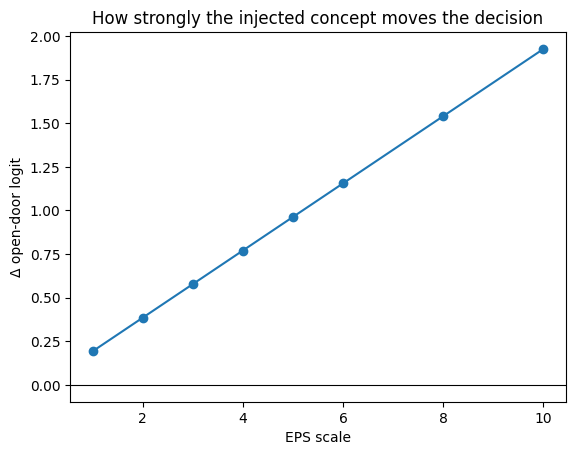

In [14]:
eps_list, delta_list = [], []

for eps in [1, 2, 3, 4, 5, 6, 8, 10]:
    def add_eps(cor, idx, _):
        x = cor.clone(); x[0, idx[1]] += eps * v_unit; return x

    idx_df = pd.DataFrame([(1, tok_action_post)],  # NEW – fresh each iter
                          columns=["layer", "pos"])

    d = generic_activation_patch(
            model.transformer,
            corrupted_tokens=tokens_corrupt,
            clean_cache=cache_clean,
            patching_metric=metric,
            patch_setter=add_eps,
            activation_name="resid_post",
            index_df=idx_df,                # use the fresh df
    )
    eps_list.append(eps); delta_list.append(d.item())

plt.figure()
plt.plot(eps_list, delta_list, marker="o")
plt.axhline(0, lw=0.8, c="k"); plt.xlabel("EPS scale")
plt.ylabel("Δ open‑door logit")
plt.title("How strongly the injected concept moves the decision"); plt.show()


## 10  Conclusion
* The probe finds a **linear “has‑key” direction** with 90 % accuracy.  
* At the door frame, the **action token attends 38 %** to the state token.  
* Injecting **+ 5 × v** into the action token raises the OPEN‑DOOR log‑odds by **≈ 1**, confirming the model *uses* this feature to decide whether to open the door.
